In [1]:

import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np # linear algebra
import pandas as pd

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.layers import PReLU

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_img_dir = "/kaggle/input/brats701515/input_data_128/train/images/"
train_mask_dir = "/kaggle/input/brats701515/input_data_128/train/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list =  sorted(os.listdir(train_mask_dir))


In [3]:
batch_size = 2
# print(train_img_list,train_mask_list)

In [4]:
def load_img(img_dir , img_list):
    
    images = []
    for i,image_name in enumerate(img_list):
        
        if(image_name.split('.')[1]=='npy'):
            # if the file is numpy array
            
            image = np.load(img_dir + image_name)
            images.append(image)
        
    images = np.array(images)
        
    return (images)

In [5]:
def imageLoader(img_dir , img_list , mask_dir , mask_list , batch_size):
    
    L = len(img_list)
    
    while True:
        
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            
            limit = min(batch_end , L)
            
            X = load_img(img_dir , img_list[batch_start:limit]) # load image
            Y = load_img(mask_dir , mask_list[batch_start:limit]) # load mask
            
            yield(X,Y) # yeilds images - a tuple with 2 numpy arrays with batch_size samples
            
            batch_start += batch_size
            batch_end += batch_size

In [6]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,  train_mask_dir, train_mask_list, batch_size)

In [7]:
img, msk = train_img_datagen.__next__()

In [8]:
img.shape

(2, 128, 128, 128, 3)

In [9]:
msk.shape

(2, 128, 128, 128, 4)

In [10]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

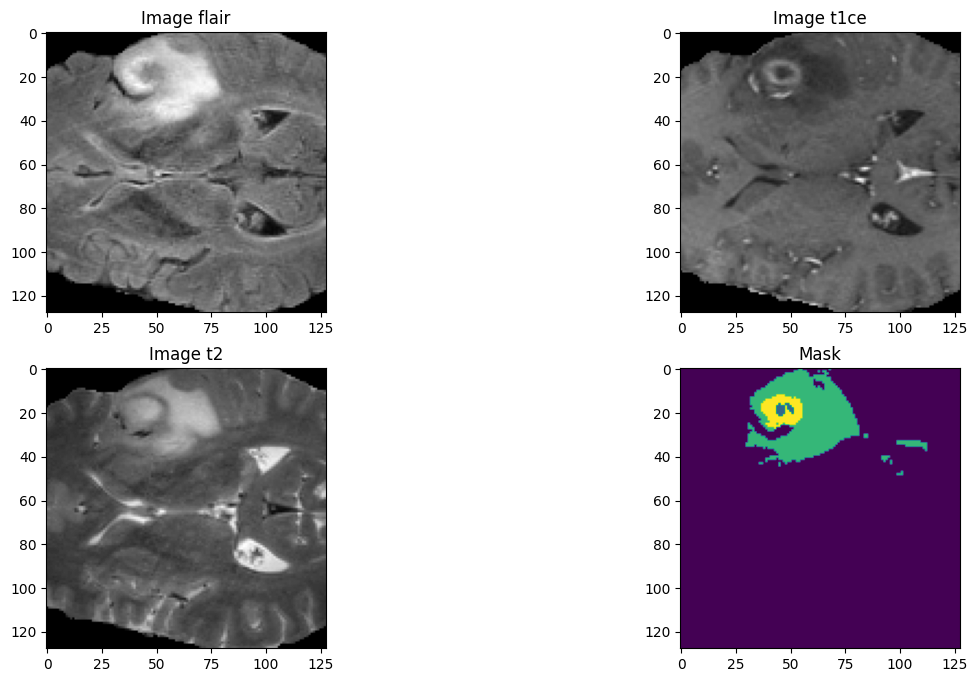

In [11]:
n_slice=random.randint(0, test_mask.shape[2])
n_slice=55
plt.figure(figsize=(15, 8))


plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [45]:
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa
import tensorflow as tf

kernel_initializer = 'he_uniform'

def attention_gate(inp_1, inp_2, channels):
    enc = Conv3D(channels, (3, 3, 3), activation='relu', padding='same')(inp_1)
    dec = Conv3D(channels, (3, 3, 3), activation='relu', padding='same')(inp_2)
    attn = Add()([enc, dec])
    attn = Conv3D(1, (1, 1, 1), activation='sigmoid')(attn)
    out = tf.keras.layers.Multiply()([inp_2, attn])
    return out

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = tf.keras.layers.SpatialDropout3D(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = tf.keras.layers.SpatialDropout3D(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.layers.SpatialDropout3D(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.layers.SpatialDropout3D(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.layers.SpatialDropout3D(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    gate1 = attention_gate(c4, u6, 128)
    u6 = concatenate([u6, gate1])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = tf.keras.layers.SpatialDropout3D(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    gate2 = attention_gate(c3, u7, 64)
    u7 = concatenate([u7, gate2])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = tf.keras.layers.SpatialDropout3D(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    gate3 = attention_gate(c2, u8, 32)
    u8 = concatenate([u8, gate3])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = tf.keras.layers.SpatialDropout3D(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    gate4 = attention_gate(c1, u9, 16)
    u9 = concatenate([u9, gate4])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = tf.keras.layers.SpatialDropout3D(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.summary()

    return model

model = simple_unet_model(128, 128, 128, 3, 4)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_124 (Conv3D)            (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization_72 (BatchN  (None, 128, 128, 12  64         ['conv3d_124[0][0]']             
 ormalization)                  8, 16)                                                      

In [13]:
# # prining the model as image 

# from tensorflow.keras.utils import plot_model
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False,
# )

In [14]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [15]:
img_list = sorted(os.listdir(train_img_dir))
print(len(img_list))
msk_list = sorted(os.listdir(train_mask_dir))
print(len(msk_list))


240
240


In [16]:
# img_list

In [17]:
num_images = len(os.listdir(train_img_dir))

In [18]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

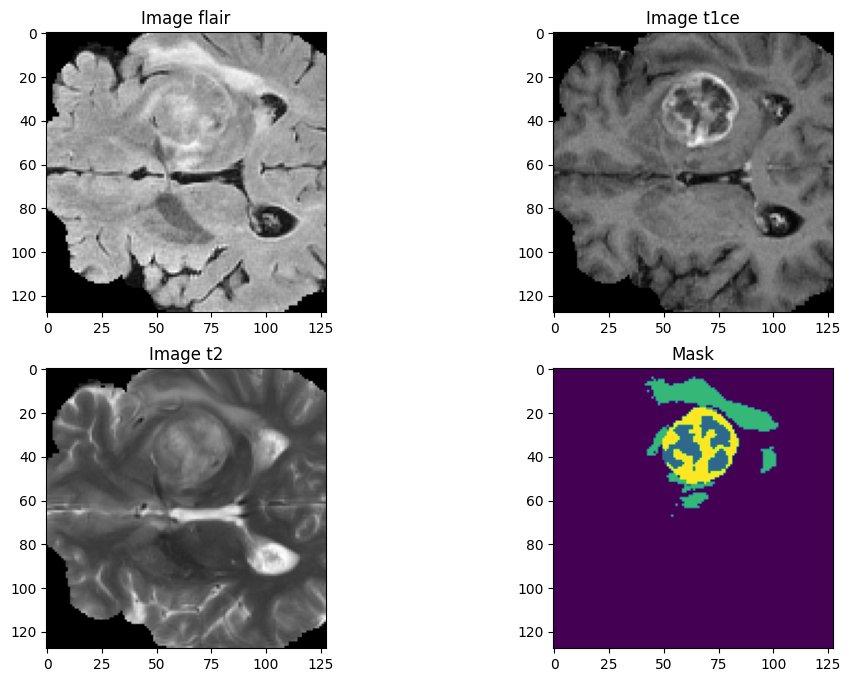

In [19]:
# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [20]:
val_img_dir = "/kaggle/input/brats701515/input_data_128/val/images/"
val_mask_dir = "/kaggle/input/brats701515/input_data_128/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))
print(len(os.listdir(val_img_dir)))
print(len(os.listdir(val_mask_dir)))

51
51


In [ ]:
image='/kaggle/input/brats701515/input_data_128/train/images/image_0.npy'
mask ='/kaggle/input/brats701515/input_data_128/train/masks/mask_0.npy'

img_num = random.randint(0,num_images-1)
test_img = np.load(image)
test_mask = np.load(mask)
test_mask = np.argmax(test_mask, axis=3)



n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [21]:
batch_size=2
train_img_datagen = imageLoader(train_img_dir, train_img_list,  train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [22]:
img, msk = train_img_datagen.__next__() 
img.shape
msk.shape

(2, 128, 128, 128, 4)

In [23]:
!pip install classification-models-3D==1.0.7
!pip install keras-applications==1.0.8
!pip install segmentation-models-3D==1.0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [32]:
import tensorflow as tf
import tensorflow.keras as keras
import segmentation_models_3D as sm
import tensorflow_addons as tfa

In [33]:
steps_per_epoch = (len(train_img_list)//batch_size )+1
val_steps_per_epoch =( len(val_img_list)//batch_size )+1 

In [54]:
import segmentation_models_3D as sm

# mean_iou = tf.keras.metrics.MeanIoU(num_classes=4)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.MeanIoU(num_classes=4)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
print(1)

1


In [55]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, name='dice_loss'):
        super(DiceLoss, self).__init__(name=name)
    def call(self, y_true, y_pred):
        smooth = 1e-15
        dice = 0
        num_classes = y_pred.shape[-1]
        for c in range(num_classes):
            intersection = tf.reduce_sum(y_true[..., c] * y_pred[..., c])
            union = tf.reduce_sum(y_true[..., c]) + tf.reduce_sum(y_pred[..., c])
            dice += (2. * intersection + smooth) / (union + smooth)
        return 1.0 - dice / num_classes
alpha = 0.5
beta = 1 - alpha
def criterion(y_true, y_pred):
    return DiceLoss()(y_true, y_pred)

In [56]:
model.compile(optimizer = optim, loss=criterion, metrics=metrics)
print(2)

2


In [57]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model with the callbacks
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.8356 - iou_score: 0.3198 - mean_io_u_3: 0.3750
Epoch 1: val_loss improved from inf to 0.75203, saving model to best_model.hdf5
121/121 [==============================] - 197s 1s/step - loss: 0.7237 - accuracy: 0.8356 - iou_score: 0.3198 - mean_io_u_3: 0.3750 - val_loss: 0.7520 - val_accuracy: 0.9432 - val_iou_score: 0.3493 - val_mean_io_u_3: 0.3750
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.8551 - iou_score: 0.3371 - mean_io_u_3: 0.3750
Epoch 2: val_loss improved from 0.75203 to 0.71488, saving model to best_model.hdf5
121/121 [==============================] - 173s 1s/step - loss: 0.7079 - accuracy: 0.8551 - iou_score: 0.3371 - mean_io_u_3: 0.3750 - val_loss: 0.7149 - val_accuracy: 0.9243 - val_iou_score: 0.3865 - val_mean_io_u_3: 0.3750
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.8711 - iou_score: 

In [ ]:
import csv
training_results = []
# Extract training metrics from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
training_iou_score = history.history['iou_score']
training_mean_iou = history.history['mean_io_u']  # Adjust the metric name as needed
validation_results = []
# Extract validation metrics from the history object (assuming it contains validation data)
validation_accuracy = history.history['val_accuracy']
validation_iou_score = history.history['val_iou_score']
validation_mean_iou = history.history['val_mean_io_u']  # Adjust the metric name as needed
# Append the training results to the list
for epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou in zip(epochs, training_accuracy, training_iou_score,training_mean_iou, validation_accuracy, validation_iou_score, validation_mean_iou):
    training_results.append([epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou])
# Define the training CSV file path
training_csv_file = '/kaggle/working/training_and_val_metrics.csv'
# Write the training results to a CSV file
with open(training_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training accuracy', 'Training iou_score', 'Training Mean IOU',  'Validation accuracy', 'Validation iou_score', 'Validation Mean IOU'])
    writer.writerows(training_results)
print(f'Training results saved to {training_csv_file}')


In [ ]:
test_img_dir = "/kaggle/input/brats701515/input_data_128/test/images/"
test_mask_dir = "/kaggle/input/brats701515/input_data_128/test/masks/"

test_img_list = sorted(os.listdir(test_img_dir))
test_mask_list = sorted(os.listdir(test_mask_dir))

batch_size=2
test_img_datagen = imageLoader(test_img_dir, test_img_list,  test_mask_dir, test_mask_list, batch_size)
test_steps_per_epoch =(len(test_img_list)//batch_size )+1 

In [ ]:
test_loss, test_accuracy, iou_score, mean_iou = model.evaluate(
    test_img_datagen, 
    steps = test_steps_per_epoch, 
    verbose=1
)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU Score: {iou_score}')
print(f'Test Mean IoU: {mean_iou}')


In [ ]:
import csv

# Define the test results
test_results = [
    ['Test Loss', test_loss],
    ['Test Accuracy', test_accuracy],
    ['Test IoU Score', iou_score],
    ['Test Mean IoU', mean_iou]
]

# Define the CSV file path
test_csv_file = '/kaggle/working/test_results.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(test_results)

print(f'Test results saved to {test_csv_file}')


In [ ]:
def dice_score(o, t, eps=1e-8):
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def softmax_output_dice(target,output):
    ret = []
    
    # whole   wt
    o = output > 0; t = target > 0 # ce
    ret += dice_score(o, t),
    
    # core   tc
    o = (output == 1) | (output == 3)
    t = (target == 1) | (target == 3)
    ret += dice_score(o, t),
    
    # active   et
    o = (output == 3);t = (target == 3)
    ret += dice_score(o, t),

    return ret


dice_scores_wt = []
dice_scores_tc = []
dice_scores_et = []
num_classes = 4

for batch in range(test_steps_per_epoch):
    
    test_img, test_mask = next(test_img_datagen)
    test_prediction = model.predict(test_img)
    
    test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
    
    tensor = softmax_output_dice(test_mask_argmax, test_prediction_argmax)
    dice_batch = tensor[0]
    dice_scores_wt.append(dice_batch)
    dice_scores_tc.append(tensor[1])
    dice_scores_et.append(tensor[2])


print("Dice Scores for Unet trained for 150 epochs with dice loss and focal loss:")
average_dice_score_et = sum(dice_scores_et) / len(dice_scores_et)
print("Average Dice Score et:", average_dice_score_et)
average_dice_score_wt = sum(dice_scores_wt) / len(dice_scores_wt)
print("Average Dice Score wt:", average_dice_score_wt)
average_dice_score_tc = sum(dice_scores_tc) / len(dice_scores_tc)
print("Average Dice Score tc:", average_dice_score_tc)



import csv

# Define the test results
average_dice_scores = [
    ['Enhanced Tumor', average_dice_score_et],
    ['Whole Tumor', average_dice_score_wt],
    ['Tumor Core', average_dice_score_tc]
]

# Define the CSV file path
test_csv_file = '/kaggle/working/dice_scores.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(average_dice_scores)

print(f'dice scores results saved to {test_csv_file}')


In [ ]:
model.save('/kaggle/working/u_net_dice_loss_150.hdf5')

In [ ]:
# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), mean_iou]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['mean_io_u']
val_acc = history.history['val_mean_io_u']

plt.plot(epochs, acc, 'y', label='Training mean_iou')
plt.plot(epochs, val_acc, 'r', label='Validation mean_iou')
plt.title('Training and validation mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou_score')
plt.plot(epochs, val_acc, 'r', label='Validation iou_score')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from keras.losses import Loss
from keras.utils import get_custom_objects
get_custom_objects().update({"criterion": criterion})


get_custom_objects().update({"iou_score": sm.metrics.IOUScore(threshold=0.5)})

get_custom_objects().update({"mean_iou_score": tf.keras.metrics.MeanIoU(num_classes=4)})

In [ ]:
my_model = load_model('/kaggle/working/u_net_dice_loss_150.hdf5')

In [ ]:
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5')
img_num = 82

test_img = np.load("/kaggle/input/brats701515/input_data_128/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("/kaggle/input/brats701515/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_mask_argmax))
print(np.unique(test_prediction_argmax))

In [ ]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()